# KerasTuner para la construccion del mejor modelo

### Cargar datos

In [1]:
# librerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

from tensorflow.keras import regularizers

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-07 10:10:23.753634: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 10:10:23.785156: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 10:10:23.824509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730992223.880780   14500 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730992223.895582   14500 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 10:10:24.166919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


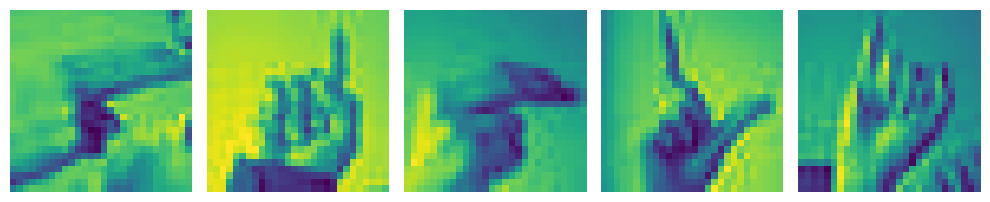

In [2]:
# ruta de los archivos
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

# data generator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# generator para test, training y validation
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para daros de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para daros de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

# clases
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']

# funcion para mostrar las imagenes
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# mostrar 5 imagenes
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Modelo a trabajar

El modelo con el que vamos a trabajar es el mismo con el que hemos venido trabajando. Vamos a definirlo

In [3]:
# funcion para generalizar la creacion del modelo
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(75, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    return model

### Implementando Autotuner

Vamos a cargar la libreria kerastuner y keras

In [4]:
import kerastuner as kt
from tensorflow import keras

/tmp/ipykernel_14500/2517507747.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Para esta ocasión crearemos un nuevo constructor de modelos, este recibirá como parámetros un objeto tuner que determinará las variaciones de diferentes hiperparámetros.

- Arquitectura general, donde agregaremos una capa de convolución, Max Pooling y aplanamiento de manera fija

- Primer variable del constructor: La cantidad de neuronas en la siguiente capa oculta, se inicializará en 16 e incrementará hasta 32 dando saltos de 8 en 8.

- La capa oculta sera de 32 neuronas.

- La cantidad de neuronas de la siguiente capa será el objeto iterador. El resto de la red se mantendrá estable.

- Variaciones en el learning rate, donde empezaremos el modelo con 3 posibles learning rate: 0.01, 0.001 y 0.0001.

- Al momento de compilar el modelo definiremos Adam como optimizador, sin embargo, llamaremos directamente a la clase y le entregaremos el objeto iterador. El resto de parámetros seguirán iguales.

In [5]:
def constructor_modelos(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape = (28,28,1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units', min_value=8, max_value=32, step=8)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

Esta función será la materia prima del tuner, el cual hará pruebas con todas las combinatorias para encontrar el modelo más optimo.

### Buscando la mejor configuracion para tu modelo

Con el generador de modelos definido podremos crear el tuner que iterará a través de la configuración expuesta.

Crearemos una instancia Hyperband (que será el objeto que iterará en las configuraciones). Sus parametros seran:

- Función generador
- Métrica objetivo (en este caso será val_accuracy para medir la precisión real del modelo)
- Máximo de 5 épocas
- factor de 2
- directorio de carga
- nombre de proyecto.

In [6]:
tuner = kt.Hyperband(
    constructor_modelos,
    objective = 'val_accuracy',
    max_epochs = 5,
    factor = 2,
    directory = './',
    project_name = 'tuner_project'
)

2024-11-07 10:10:34.050070: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Con en tuner generado, podremos empezar nuestra búsqueda. Entregamos al método:
- el dataset
- las épocas máximas
- los datos de validación

Empezamos el entrenamiento y esperamos a que se complete. Guardaremos el mejor desempeño en la variable best_hps

In [7]:
tuner.search(
    train_generator, 
    epochs=10, 
    validation_data= validation_generator
    )

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 19 Complete [00h 02m 47s]
val_accuracy: 0.5431578755378723

Best val_accuracy So Far: 0.6715789437294006
Total elapsed time: 00h 27m 39s


Para obtener las mejores configuraciones haremos uso del método get

In [9]:
# numero de neuronas optimas
print(best_hps.get('units'))

24


In [10]:
# tasa de aprendizaje optimo
print(best_hps.get('learning_rate'))

0.01


> El mejor modelo posee 24 neuronas y una taza de aprendizaje de 0.01

### Creando un modelo a partir de la mejor configuracion

Con los mejores hiperparámetros encontrados podremos construir un modelo optimizado, esto lo haremos con el método hypermodel.build de tuner que recibirá la configuración como argumento.

Ahora tenemos un modelo listo para ser entrenado, agregaremos el callback de early stopping para evitar sobre entrenamientos innecesarios.

In [11]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    mode='auto'
)

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = 20,
    callbacks = [callback_early],
    validation_data = validation_generator
)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.0403 - loss: 3.2564 - val_accuracy: 0.0225 - val_loss: 3.2069
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.0493 - loss: 3.1789 - val_accuracy: 0.0196 - val_loss: 3.2028
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.0447 - loss: 3.1782 - val_accuracy: 0.0225 - val_loss: 3.2027


> El early sttoping detecto que no estaba mejorando el modelo en cada epoca por lo que detuvo el entrenamiento.

> El modelo alcanza un valor 0.0447 en accuracy de entrenamiento

